In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xllm-speech-ner-data/dev_transcriptions.csv
/kaggle/input/xllm-speech-ner-data/transcriptions - transcriptions.csv
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/run.py
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/run.bash
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/README.md
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/requirements.txt
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/seq2seq/modelBuilder.py
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/seq2seq/sentence_splitter.py
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/seq2seq/utils.py
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/seq2seq/label_smoother_sum.py
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/seq2seq/constrained_seq2seq.py
/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/seq2seq/__init__.py
/kaggle/input/xllm-speech-ner-data/SpeechEE-mai

In [2]:
!pip install transformers datasets accelerate peft bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 21.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 16.9 MB/s eta 0:00:00


In [4]:
transcripts_df = pd.read_csv('/kaggle/input/xllm-speech-ner-data/transcriptions - transcriptions.csv')
transcripts_df.sample(10)

,File Name,Transcription
4722,train-10589.wav,"Oh, uh-huh."
9717,train-18281.wav,And now just so you don't think that every ent...
13099,train-6191.wav,At the time Martha Stewart was worth in the ne...
9749,train-140.wav,And the Democrats need desperately to get a me...
5790,train-12985.wav,Tom Racings
18443,train-11948.wav,I don't know. I think that's great.
12943,train-2803.wav,It would talk about tips again. Woodruff. Wood...
11783,train-463.wav,I did not feel less than
3180,train-2041.wav,They got to understand he wants us here.
1093,train-2815.wav,"Famed World War II reporter, Bernie Pyle was ..."


In [5]:
dev_transcriptions_df = pd.read_csv('/kaggle/input/xllm-speech-ner-data/dev_transcriptions.csv')
dev_transcriptions_df.sample(10)

,File Name,Transcription
579,dev-252.wav,That will take place soon.
898,dev-149.wav,"with much of this weaponry, there is only one..."
682,dev-570.wav,Most US Army commanders believe it is critica...
801,dev-105.wav,And this is a very busy base. I...
301,dev-375.wav,A million dollars is okay. Maybe like five mi...
642,dev-870.wav,Our offices are in one of the patio homes and...
882,dev-767.wav,These are the reasons that none of these moth...
494,dev-718.wav,Nathan Garber
535,dev-261.wav,But I also should report that there is a sens...
42,dev-800.wav,Why would an NBC reporter who also reports on...


In [6]:
transcripts_df = pd.concat([transcripts_df, dev_transcriptions_df], ignore_index=True)
transcripts_df.sample(20)

,File Name,Transcription
16631,train-9251.wav,And the job is on our...
18275,train-13609.wav,"In 1999, East to more became free, but only a..."
2052,train-15527.wav,So don't give up on the idea of a natural birt...
9374,train-8031.wav,Well
18751,train-12566.wav,"You know, you had to cross a little walking, ..."
16030,train-12688.wav,NaN
5725,train-14303.wav,Brown takes over a team that won an Eastern C...
10229,train-16522.wav,Some people like Gary Manelow.
732,train-11412.wav,like
4344,train-16354.wav,I wouldn't have done that from LHR to the hot...


In [7]:
import json

event_schema_json_path = '/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/challenge/event-schema.json'

with open(event_schema_json_path, 'r') as f:
    event_schema = json.load(f)

print(event_schema)

{'Event Type': ['Injure', 'Charge-Indict', 'Execute', 'Merge-Org', 'Start-Position', 'Die', 'Acquit', 'Extradite', 'Pardon', 'Convict', 'Phone-Write', 'End-Org', 'Release-Parole', 'Transfer-Money', 'Marry', 'Appeal', 'Fine', 'Be-Born', 'Transport', 'Sentence', 'Declare-Bankruptcy', 'Divorce', 'Meet', 'Demonstrate', 'Attack', 'Start-Org', 'Arrest-Jail', 'Elect', 'End-Position', 'Sue', 'Trial-Hearing', 'Nominate', 'Transfer-Ownership'], 'Argument Role': ['Instrument', 'Seller', 'Entity', 'Person', 'Attacker', 'Org', 'Beneficiary', 'Victim', 'Target', 'Buyer', 'Plaintiff', 'Agent', 'Artifact', 'Adjudicator', 'Defendant', 'Place', 'Prosecutor', 'Giver', 'Destination', 'Origin', 'Vehicle', 'Recipient'], 'Event Schema': {'Start-Org': ['Agent', 'Org', 'Place'], 'Die': ['Instrument', 'Place', 'Victim', 'Person', 'Agent'], 'Start-Position': ['Person', 'Entity', 'Place'], 'Acquit': ['Adjudicator', 'Defendant'], 'Trial-Hearing': ['Place', 'Prosecutor', 'Adjudicator', 'Defendant'], 'Attack': ['Ins

In [8]:
type(event_schema)

dict

In [9]:
import json

train_event_json_path = '/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/challenge/data/ACE05EN/train.jsonl'

train_event = []
with open(train_event_json_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        if len(data['event']) != 0:
            train_event.append(data)

print(len(train_event))

3342


In [10]:
train_event[:2]

[{'id': 'train-3',
  'event': [{'trigger': 'landed',
    'type': 'Transport',
    'arguments': [{'name': 'boat', 'role': 'Vehicle'},
     {'name': 'men', 'role': 'Artifact'},
     {'name': 'shores', 'role': 'Destination'}]}]},
 {'id': 'train-6',
  'event': [{'trigger': 'election',
    'type': 'Elect',
    'arguments': [{'name': 'man', 'role': 'Person'}]}]}]

In [11]:
dev_event_json_path = '/kaggle/input/xllm-speech-ner-data/SpeechEE-main/SpeechEE-main/challenge/data/ACE05EN/dev.jsonl'

dev_event = []
with open(dev_event_json_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        if len(data['event']) != 0:
            dev_event.append(data)

print(len(dev_event))

327


In [12]:
dev_event[:2]

[{'id': 'dev-2',
  'event': [{'trigger': 'deploy',
    'type': 'Transport',
    'arguments': [{'name': 'soldiers', 'role': 'Artifact'},
     {'name': 'region', 'role': 'Destination'}]}]},
 {'id': 'dev-4',
  'event': [{'trigger': 'war', 'type': 'Attack', 'arguments': []},
   {'trigger': 'former',
    'type': 'End-Position',
    'arguments': [{'name': 'Tom Andrews', 'role': 'Person'},
     {'name': 'Maine', 'role': 'Entity'}]}]}]

In [13]:
train_event.extend(dev_event)

In [14]:
len(train_event)

3669

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# sentence = "The boat landed on the shores."
# trigger = "landed"
# label = "Transport"

# tokens = tokenizer.tokenize(sentence)
# labels = ["O"] * len(tokens)

# # Set the label at the trigger index
# trigger_index = tokens.index(trigger)
# labels[trigger_index] = label

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [16]:
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import AutoTokenizer
from collections import defaultdict
import pandas as pd
import json

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

file_to_transcription = {
    row["File Name"]: row["Transcription"] for _, row in transcripts_df.iterrows()
}

input_ids_list = []
attention_masks_list = []
labels_list = []

# Collect all labels to create label2id map
all_label_set = set()

for event_data in tqdm(train_event, desc="Processing Events"):
    file_id = f"{event_data['id']}.wav"
    if file_id not in file_to_transcription:
        continue
    sentence = file_to_transcription[file_id]
    if not isinstance(sentence, str):
        continue
    sentence_tokens = tokenizer.tokenize(sentence)
    sentence_ids = tokenizer.convert_tokens_to_ids(sentence_tokens)
    temp_labels = ["O"] * len(sentence_tokens)

    for event in event_data["event"]:
        event_type = event["type"]

        # Label trigger
        trigger_tokens = tokenizer.tokenize(event["trigger"])
        for i in range(len(sentence_tokens) - len(trigger_tokens) + 1):
            if sentence_tokens[i:i+len(trigger_tokens)] == trigger_tokens:
                for j in range(len(trigger_tokens)):
                    temp_labels[i + j] = f"{event_type}"
                break

        # Label arguments
        for arg in event.get("arguments", []):
            arg_tokens = tokenizer.tokenize(arg["name"])
            arg_label = f"{event_type}-{arg['role']}"
            for i in range(len(sentence_tokens) - len(arg_tokens) + 1):
                if sentence_tokens[i:i+len(arg_tokens)] == arg_tokens:
                    for j in range(len(arg_tokens)):
                        temp_labels[i + j] = arg_label
                    break

    all_label_set.update(temp_labels)

    input_ids_list.append(sentence_ids)
    attention_masks_list.append([1] * len(sentence_ids))
    labels_list.append(temp_labels)


Processing Events: 100%|██████████| 3669/3669 [00:01<00:00, 2553.48it/s]


In [17]:
all_labels = sorted(list(all_label_set))
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}
num_labels = len(label2id)

In [18]:
class EventNERDataset(Dataset):
    def __init__(self, input_ids_list, attention_masks_list, labels_list, label2id, max_length=128):
        self.input_ids_list = input_ids_list
        self.attention_masks_list = attention_masks_list
        self.labels_list = labels_list
        self.label2id = label2id
        self.max_length = max_length

    def __len__(self):
        return len(self.input_ids_list)

    def __getitem__(self, idx):
        input_ids = self.input_ids_list[idx]
        attention_mask = self.attention_masks_list[idx]
        label_strs = self.labels_list[idx]

        # Padding
        padding_len = self.max_length - len(input_ids)
        input_ids = input_ids + [tokenizer.pad_token_id] * padding_len
        attention_mask = attention_mask + [0] * padding_len
        labels = [self.label2id[label] for label in label_strs] + [-100] * padding_len

        return {
            "input_ids": torch.tensor(input_ids),
            "attention_mask": torch.tensor(attention_mask),
            "labels": torch.tensor(labels),
        }

In [19]:
dataset = EventNERDataset(
    input_ids_list=input_ids_list,
    attention_masks_list=attention_masks_list,
    labels_list=labels_list,
    label2id=label2id,
    max_length=128
)

In [20]:
print("✅ Dataset ready!")
print("Total examples:", len(dataset))
print("Number of labels:", num_labels)
print("Sample label mapping:", label2id)

✅ Dataset ready!
Total examples: 3667
Number of labels: 134
Sample label mapping: {'Acquit': 0, 'Acquit-Adjudicator': 1, 'Acquit-Defendant': 2, 'Appeal': 3, 'Appeal-Adjudicator': 4, 'Appeal-Place': 5, 'Appeal-Plaintiff': 6, 'Arrest-Jail': 7, 'Arrest-Jail-Agent': 8, 'Arrest-Jail-Person': 9, 'Arrest-Jail-Place': 10, 'Attack': 11, 'Attack-Attacker': 12, 'Attack-Instrument': 13, 'Attack-Place': 14, 'Attack-Target': 15, 'Attack-Victim': 16, 'Be-Born': 17, 'Be-Born-Person': 18, 'Be-Born-Place': 19, 'Charge-Indict': 20, 'Charge-Indict-Adjudicator': 21, 'Charge-Indict-Defendant': 22, 'Charge-Indict-Place': 23, 'Charge-Indict-Prosecutor': 24, 'Convict': 25, 'Convict-Adjudicator': 26, 'Convict-Defendant': 27, 'Convict-Place': 28, 'Declare-Bankruptcy': 29, 'Declare-Bankruptcy-Org': 30, 'Demonstrate': 31, 'Demonstrate-Entity': 32, 'Demonstrate-Place': 33, 'Die': 34, 'Die-Agent': 35, 'Die-Instrument': 36, 'Die-Person': 37, 'Die-Place': 38, 'Die-Victim': 39, 'Divorce': 40, 'Divorce-Person': 41, 'Ele

In [21]:
sample_idx = 0
file_id = f"{train_event[sample_idx]['id']}.wav"
sentence = file_to_transcription.get(file_id, "")


tokens = tokenizer.tokenize(sentence)
labels = labels_list[sample_idx]


print("Original Sentence:")
print(sentence)
print("\nTokenized Sentence with Labels:")
for tok, label in zip(tokens, labels):
    print(f"{tok:15} --> {label}")


Original Sentence:
 Even as the Secretary of Homeland Security was putting his people on high alert last month, a 30-foot Cuban patrol boat with four heavily armed men landed on American shores. Underly undetected by the Coast Guard Secretary Ridge now leads.

Tokenized Sentence with Labels:
Even            --> O
as              --> O
the             --> O
Secretary       --> O
of              --> O
Homeland        --> O
Security        --> O
was             --> O
putting         --> O
his             --> O
people          --> O
on              --> O
high            --> O
alert           --> O
last            --> O
month           --> O
,               --> O
a               --> O
30              --> O
-               --> O
foot            --> O
Cuban           --> O
patrol          --> O
boat            --> Transport-Vehicle
with            --> O
four            --> O
heavily         --> O
armed           --> O
men             --> Transport-Artifact
landed          --> Transport
on    

In [22]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [23]:
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm


model_name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

train_indices, val_indices = train_test_split(list(range(len(input_ids_list))), test_size=0.01, random_state=42)



train_dataset = EventNERDataset(
    [input_ids_list[i] for i in train_indices],
    [attention_masks_list[i] for i in train_indices],
    [labels_list[i] for i in train_indices],
    label2id
)

val_dataset = EventNERDataset(
    [input_ids_list[i] for i in val_indices],
    [attention_masks_list[i] for i in val_indices],
    [labels_list[i] for i in val_indices],
    label2id
)



data_collator = DataCollatorForTokenClassification(tokenizer)


training_args = TrainingArguments(
    output_dir="./bert-ner-finetuned",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# Evaluation metric (simple accuracy)
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=2)

    true_preds, true_labels = [], []
    for pred, label in zip(predictions, labels):
        true_preds.extend([p for (p, l) in zip(pred, label) if l != -100])
        true_labels.extend([l for (p, l) in zip(pred, label) if l != -100])

    acc = (np.array(true_preds) == np.array(true_labels)).mean()
    return {"accuracy": acc}

# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([134]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]

In [24]:
# Train
trainer.train()

# Save
trainer.save_model("./bert-ner-finetuned")
tokenizer.save_pretrained("./bert-ner-finetuned")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.558600,0.453658,0.905896
2,0.293000,0.387865,0.905896
3,0.227000,0.401112,0.904762


('./bert-ner-finetuned/tokenizer_config.json',
 './bert-ner-finetuned/special_tokens_map.json',
 './bert-ner-finetuned/vocab.txt',
 './bert-ner-finetuned/added_tokens.json',
 './bert-ner-finetuned/tokenizer.json')

In [25]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Save model and tokenizer
model.save_pretrained("./bert-finetuned-event-ner")
tokenizer.save_pretrained("./bert-finetuned-event-ner")

('./bert-finetuned-event-ner/tokenizer_config.json',
 './bert-finetuned-event-ner/special_tokens_map.json',
 './bert-finetuned-event-ner/vocab.txt',
 './bert-finetuned-event-ner/added_tokens.json',
 './bert-finetuned-event-ner/tokenizer.json')

In [26]:
import shutil

shutil.make_archive("bert-finetuned-event-ner", 'zip', "./bert-finetuned-event-ner")

'/kaggle/working/bert-finetuned-event-ner.zip'

In [69]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

model_path = "./bert-ner-finetuned"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="average", device=-1)

sentence = "British Chancellor of the Act Checker, Gordon Brown on Tuesday, made the current hit of the country's energy regulator as the new chairman of Finance Warstock, the Financial Services Authority."

outputs = ner_pipeline(sentence)

for entity in outputs:
    print(f"{entity['word']}\t{entity['entity_group']}\t{entity['score']:.2f}")


Device set to use cpu


Brown	Artifact	0.03
Financial Services Authority	Org-Org	0.05


In [29]:
!pip install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 10.8 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 4.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803405 sha256=c0876fb535c4ee7a3a37dbd45d1d18aa70f07c7b63bf34e77257e737f8b39b09
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [31]:
import os
import pandas as pd
import whisper
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

def transcribe_wav_to_csv(folder_path, output_csv):
    model = whisper.load_model("base", device="cpu")

    results = []

    wav_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    for file_name in tqdm(wav_files):
        file_path = os.path.join(folder_path, file_name)
        transcription = model.transcribe(file_path, language="en", fp16=False)
        results.append({
            "File Name": file_name,
            "Transcription": transcription['text']
        })

    pd.DataFrame(results).to_csv(output_csv, index=False)

folder_path = "/kaggle/input/xllm-speech-ner-data/test/test"
output_csv = "/kaggle/working/test_transcriptions.csv"

transcribe_wav_to_csv(folder_path, output_csv)


100%|██████████| 676/676 [23:43<00:00,  2.11s/it]


In [33]:
dev_transcriptions_df = pd.read_csv('/kaggle/input/xllm-speech-ner-data/dev_transcriptions.csv')
dev_transcriptions_df.sample(10)

,File Name,Transcription
70,dev-582.wav,We cannot predict the final day of the Iraq r...
235,dev-417.wav,"It's really, really extraordinary."
430,dev-852.wav,Some of those interviewed try to make it soun...
412,dev-215.wav,So let's see Reshannon-S-E-Rat.
39,dev-809.wav,The truth is that as director of UN peacekeep...
670,dev-422.wav,"A source of convicted, rapist, max factor air..."
736,dev-339.wav,The first departures are already underway at ...
110,dev-349.wav,"They will learn that once they get there, the..."
72,dev-299.wav,Airlines reported fewer complaints about loss...
86,dev-86.wav,"Again, we know where we're going."


In [64]:
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from tqdm import tqdm

model_path = "./bert-ner-finetuned"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first", device=-1)

test_transcription_df = pd.read_csv("/kaggle/input/xllm-speech-ner-data/test_transcriptions.csv")

results = []

for _, row in tqdm(test_transcription_df.iterrows(), total=len(test_transcription_df), desc="NER Inference"):
    file_id = row['File Name'].replace(".wav", "")
    sentence = str(row['Transcription']) if pd.notnull(row['Transcription']) else ""

    entities = ner_pipeline(sentence)

    if not entities:
        results.append({"id": file_id, "event": []})
        continue

    # Placeholder logic for role assignment and trigger selection
    arguments = []
    trigger = entities[0]['word']
    event_type = entities[0]['entity_group']
    # print(entities)
    for ent in entities[1:]:
        # print(ent)
        arguments.append({
            "name": ent['word'],
            "role": ent['entity_group']
        })

    results.append({
        "id": file_id,
        "event": [
            {
                "trigger": trigger,
                "type": event_type,
                "arguments": arguments
            }
        ]
    })
sorted_results = sorted(results, key=lambda x: int(x['id'].split('-')[1]))
output_path = "/kaggle/working/results.json"
with open(output_path, "w") as f:
    json.dump(sorted_results, f)

print(f"✅ JSONL file saved at: {output_path}")


Device set to use cpu
NER Inference: 100%|██████████| 676/676 [01:05<00:00, 10.31it/s]


✅ JSONL file saved at: /kaggle/working/results.json


In [65]:
sorted_results[:10]

[{'id': 'test-0', 'event': []},
 {'id': 'test-1',
  'event': [{'trigger': 'Brown',
    'type': 'Artifact',
    'arguments': [{'name': 'Warstock', 'role': 'Org-Org'},
     {'name': 'Financial Services Authority', 'role': 'Org-Org'}]}]},
 {'id': 'test-2',
  'event': [{'trigger': 'McCarthy',
    'type': 'Entity',
    'arguments': [{'name': 'London', 'role': 'Place'},
     {'name': 'Davies', 'role': 'Position-Person'},
     {'name': 'steps down', 'role': 'Position'}]}]},
 {'id': 'test-3',
  'event': [{'trigger': 'Economics',
    'type': 'Org-Org',
    'arguments': [{'name': 'London', 'role': 'Org-Org'}]}]},
 {'id': 'test-4', 'event': []},
 {'id': 'test-5',
  'event': [{'trigger': 'Office of Gas and Electricity Markets',
    'type': 'Org-Org',
    'arguments': [{'name': 'Britain', 'role': 'Place'}]}]},
 {'id': 'test-6',
  'event': [{'trigger': 'Barclays Bank',
    'type': 'Org-Org',
    'arguments': [{'name': 'Benson', 'role': 'Org-Org'},
     {'name': 'of Trade and Industry', 'role': 'Org-

In [32]:
import time

while True:
    print("Keeping CPU busy...")
    time.sleep(300)

Keeping CPU busy...


KeyboardInterrupt: 

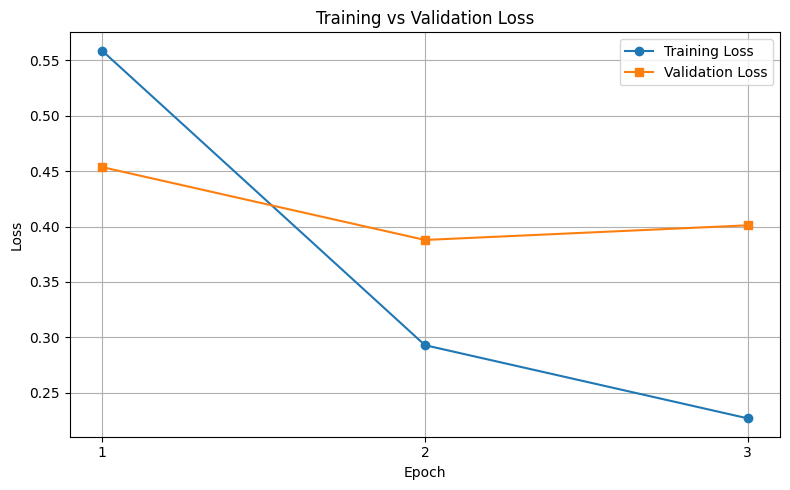

In [1]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3]
training_loss = [0.5586, 0.2930, 0.2270]
validation_loss = [0.4536, 0.3879, 0.4011]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='s', label='Validation Loss')
plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

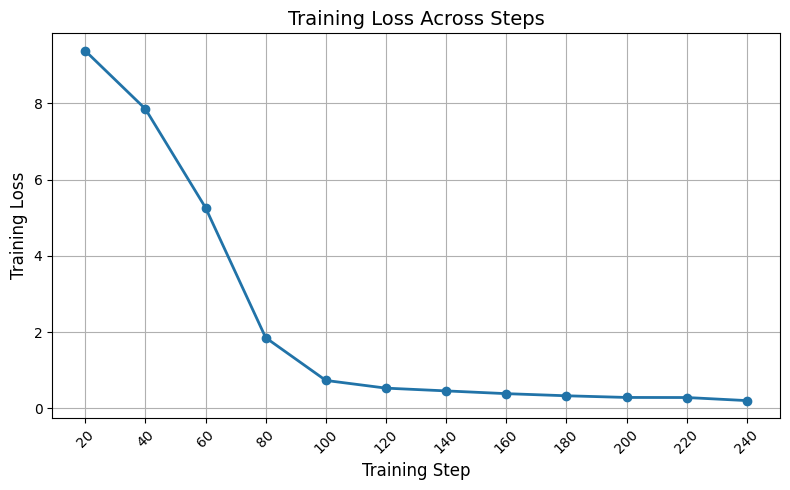

In [4]:
import matplotlib.pyplot as plt

# Data from table
steps = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]
training_loss = [9.3754, 7.8513, 5.2618, 1.8522, 0.7312, 0.5293, 0.4567,
                 0.3846, 0.3289, 0.2850, 0.2831, 0.2025 ]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, training_loss, marker='o', color='#2173a8', linestyle='-', linewidth=2)
plt.title('Training Loss Across Steps', fontsize=14)
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.grid(True)
plt.xticks(steps, rotation=45)
plt.tight_layout()

# Show plot
plt.show()
